In [12]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

nnodes = 107  # nodes

# Horizon for each problem
ndays = 'full'
n_int_steps = 1
when = 'future'

setup = ItalySetup(nnodes, ndays)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [13]:
mydata = pd.read_csv('model_output/FR1-T10-int107-r0-m0.csv', index_col= 'date', parse_dates=True, )
mydata[mydata['value']<0]

,comp,place,value,placeID
date,,,,


In [15]:
myopt = None

In [ ]:
myopt = pd.read_csv('model_output/20201129-opt107-r4000-m15000000.0.csv', index_col= 'date', parse_dates=True, )

# Comparisons with matlab integration

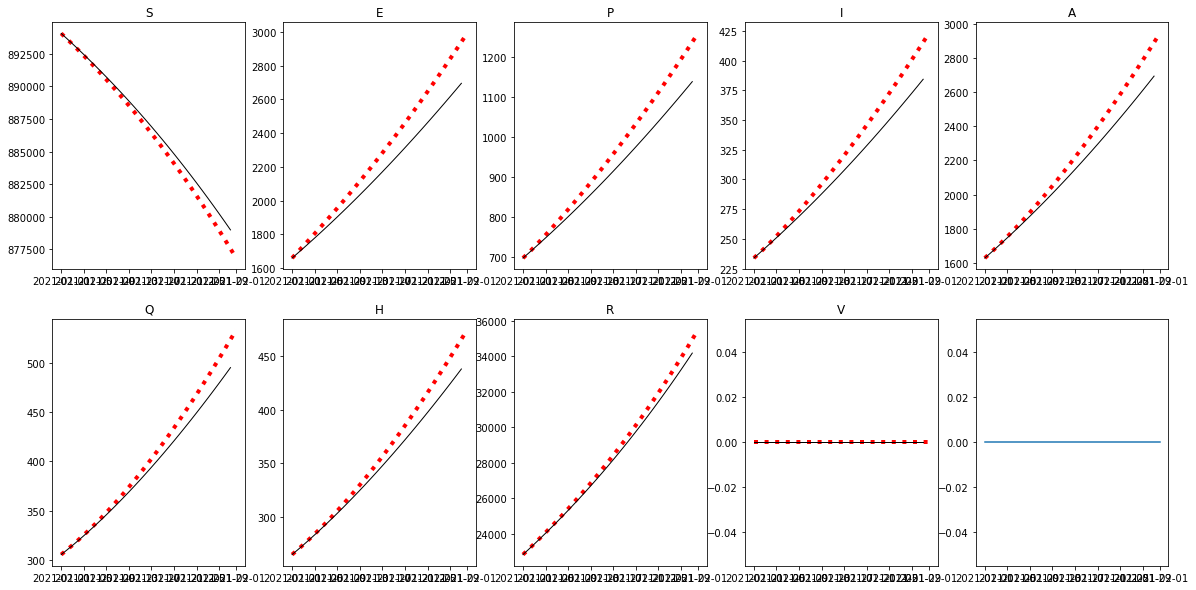

In [27]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 60

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if myopt is not None:
        axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");
if myopt is not None:
    axes.flat[-1].step(myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'].index,
                       myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'], label=r"$\nu(t)$");

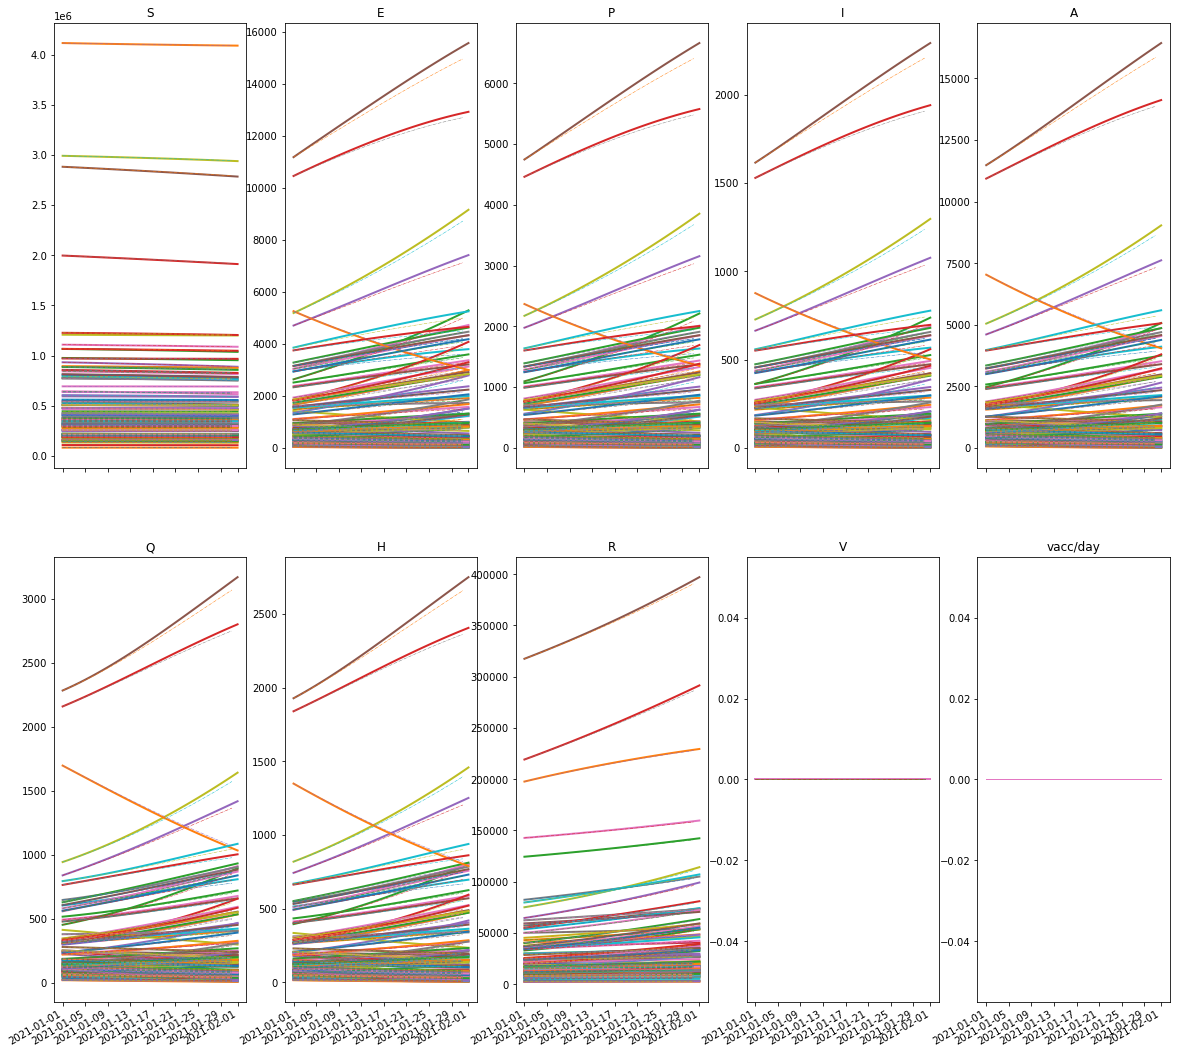

In [26]:
fig, axes = plt.subplots(2,5, figsize = (20,20), sharex=True)
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 1, ls = '-');
#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()

,comp,place,value,placeID
date,,,,


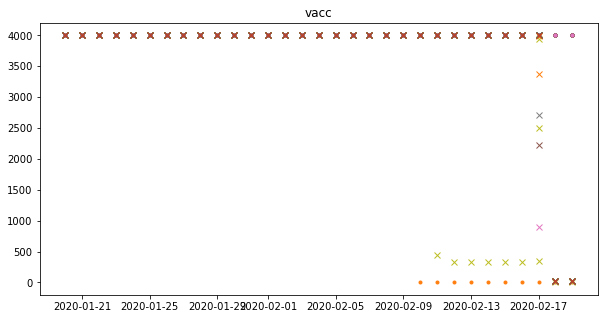

In [63]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'

ax.plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values='value'), lw = 3, ls = '', marker='.')
ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st);


I


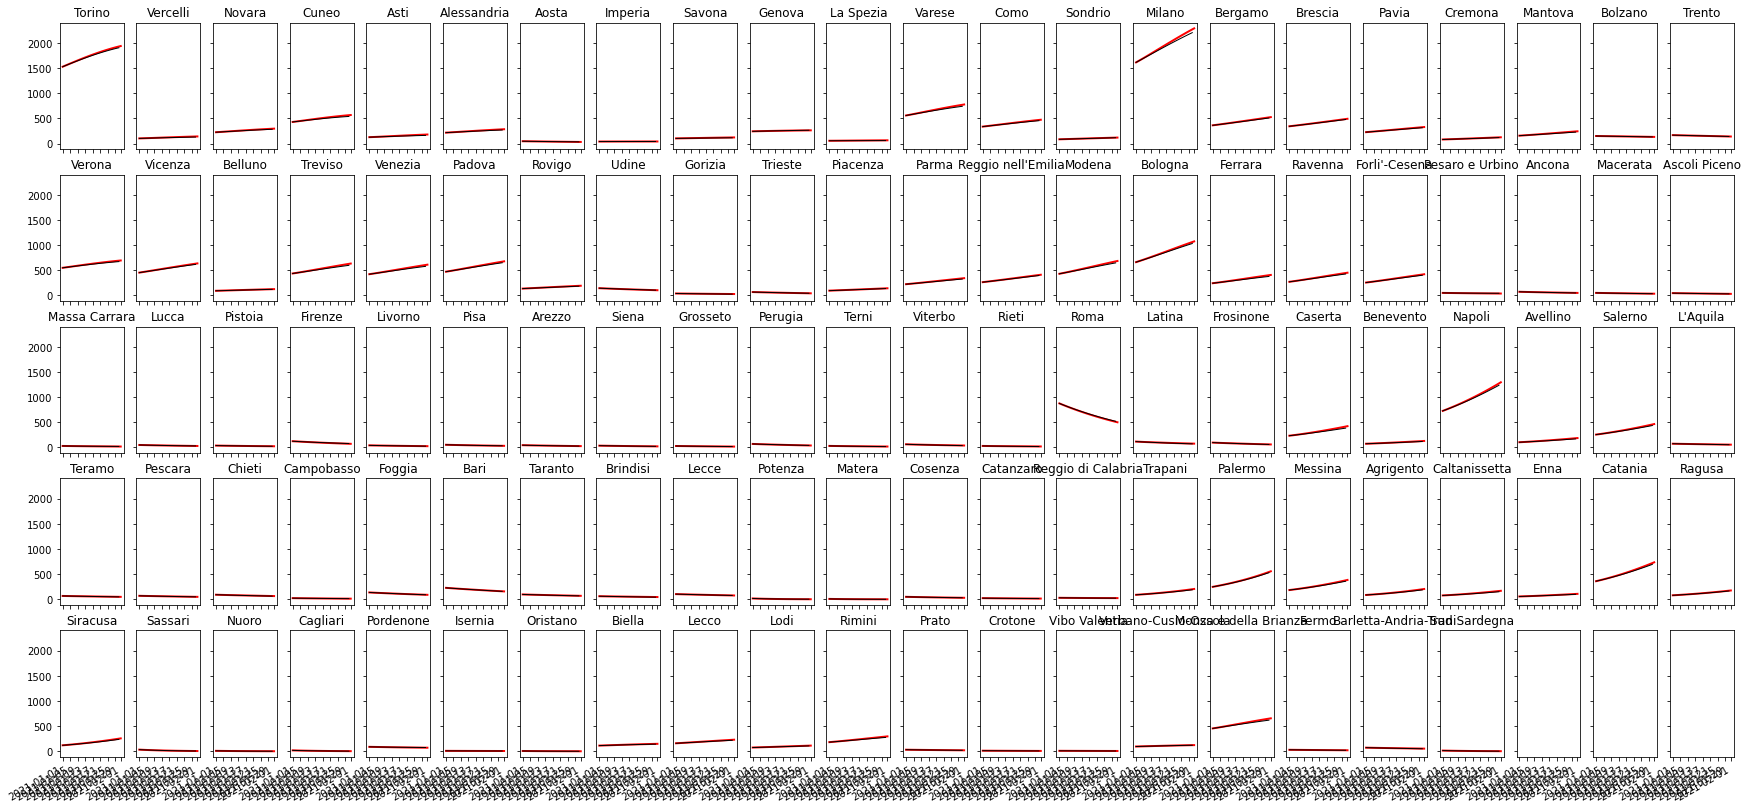

In [33]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white', sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].bar(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'].index,
    #                 mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], #linestyle='-', lw = 3,  marker='', 
    #                 color='orange')
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='-', lw = 2, color='r')#, marker='.')

    
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
fig.autofmt_xdate()

# Compare scenarios

In [105]:
scenarios = [ 'C', 'L'] # 'U',
mydata = {}
for scn in scenarios:
    mydata[scn] = pd.read_csv(f'model_output/FR-{scn}-R1-T10-int107-nc.csv', index_col= 'date', parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: 'model_output/FR-L-R1-T10-int107-nc.csv'

I


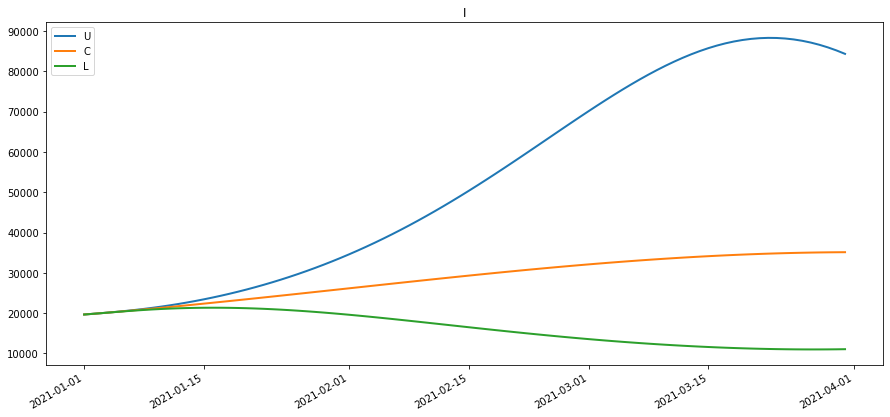

In [97]:
fig, axes = plt.subplots(1,1, figsize = (15,7), facecolor = 'white')
i = 3
st = states_names[i]
print(st)

for scn in scenarios:
    md = mydata[scn]
    axes.plot(md[(md['comp'] == st)].groupby('date').sum()['value'], linestyle='-', lw = 2, label = scn)
axes.set_title(st)
    
axes.legend()
fig.autofmt_xdate()

In [98]:
md[(md['comp'] == st)].groupby('date').sum()['value']

date
2021-01-01    19658.976218
2021-01-02    19822.602141
2021-01-03    19990.939663
2021-01-04    20161.552435
2021-01-05    20330.239115
                  ...     
2021-03-27    10993.040393
2021-03-28    10994.675066
2021-03-29    11005.178723
2021-03-30    11024.796018
2021-03-31    11053.792962
Name: value, Length: 90, dtype: float64

I


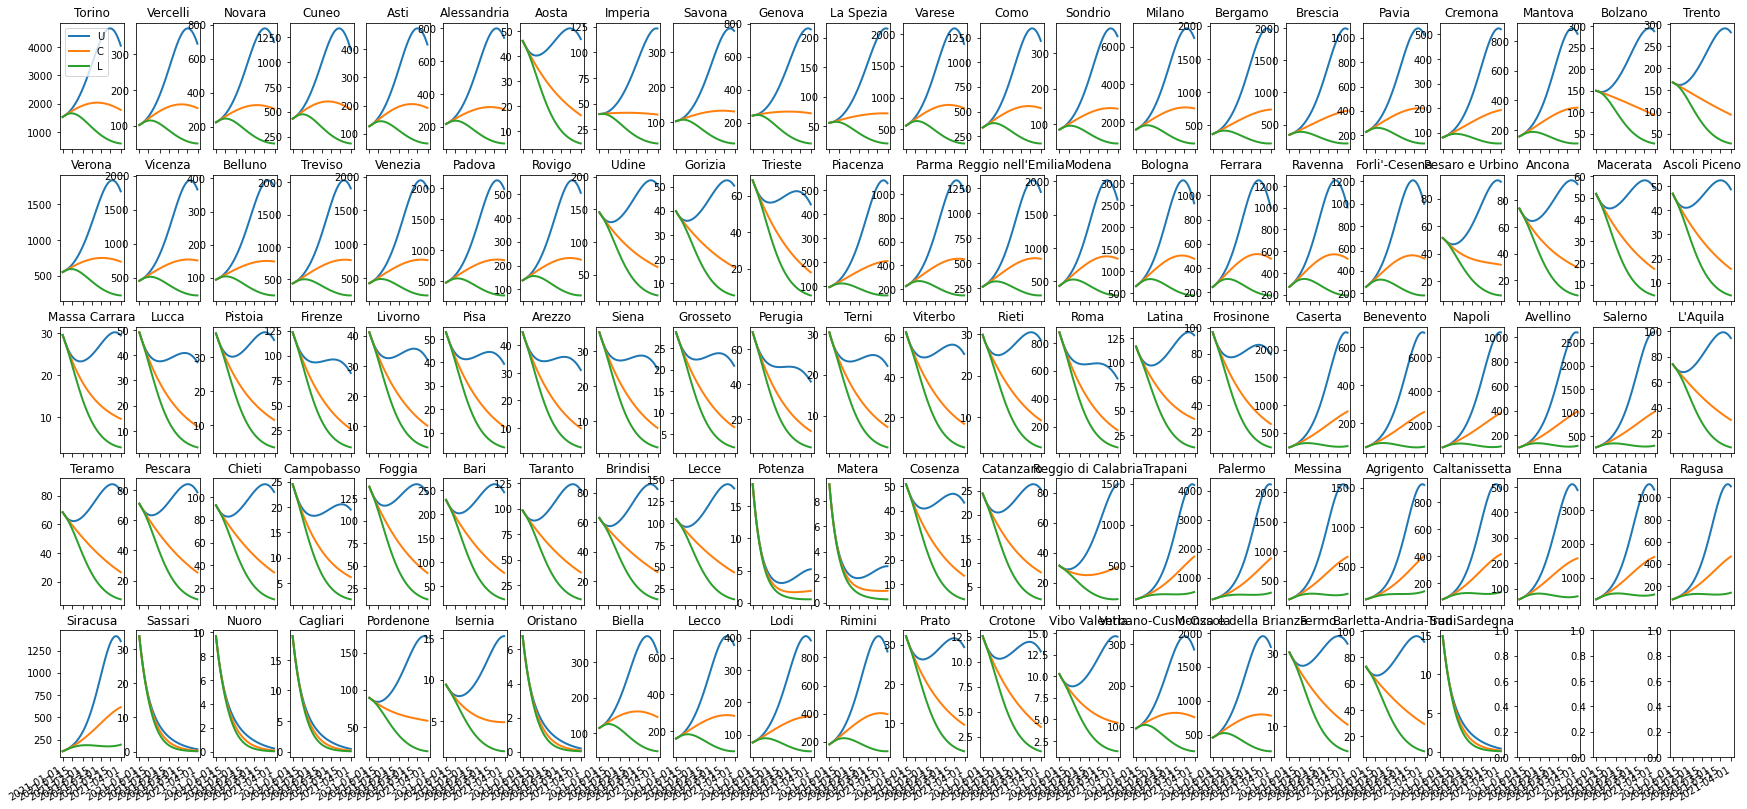

In [99]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white')#, sharey=True)
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    for scn in scenarios:
        md = mydata[scn]
        axes.flat[k].plot(md[(md['comp'] == st) & (md['placeID'] == k)]['value'], linestyle='-', lw = 2, label = scn)
    axes.flat[k].set_title(nname)
    
axes.flat[0].legend()
fig.autofmt_xdate()

In [4]:

outdir = 'model_output/'
file_prefix = f'scnMaxVacc4000short'
mvr = 4000
scn_results = pd.DataFrame(columns=['total_vacc', 'method', 'infected'])
methods = ['opt', 'int', 'inc', 'pop']
for met in methods:
    scn_maxvacc = [1e6, 4e6, 8e6, 12e6, 16e6, 20e6]
    for scn_id, scn_maxvacc in enumerate(scn_maxvacc):
        md = pd.read_csv(f'{outdir}{file_prefix}-{met}{nnodes}-r{mvr}-m{int(scn_maxvacc)}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'total_vacc':[int(scn_maxvacc)],
                                                                      'method': [met],
                                                                      'infected':[infected]
                                                                     })])
                                
                    
    md = pd.read_csv(f'{outdir}{file_prefix}-int{nnodes}-r0-m0.csv', index_col= 'date', parse_dates=True)
    infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
    scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'total_vacc':[int(0)],
                                                                          'method': [met],
                                                                          'infected':[infected]
                                                                         })])
    scn_results['averted'] = max(scn_results['infected']) - scn_results['infected']                                       

In [169]:
def generate_alternatives(no_vacc):
    
    
    ndays = 45  # 'full'
    use_matlab = False

    n_int_steps = 1

    setup = ItalySetup(nnodes, ndays)
    M = setup.nnodes
    N = len(setup.model_days) - 1
    scn_maxvacc = [1e6, 4e6, 8e6, 12e6, 16e6, 20e6]
    # BY INCIDENCE: 
    incid = no_vacc[no_vacc['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    for scn_id, scn_maxvacc in enumerate(scn_maxvacc):
        control_initial = np.zeros((M, N))
        max_vacc_rate = np.zeros((M, N))
        allocated_total = 0
        unvac_nd = np.copy(setup.pop_node)

        for nd in incid.sort_values('value', ascending=False).index:
            for k in range(N):
                max_vacc_rate[nd, k] = mvr
                if (allocated_total + mvr < scn_maxvacc) and (unvac_nd[nd] - mvr > 0):
                    control_initial[nd, k] = mvr
                    allocated_total += mvr
                    unvac_nd[nd] -= mvr

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'{outdir}{file_prefix}-inc{nnodes}-r{mvr}-m{int(scn_maxvacc)}',
                                                                          n_rk4_steps=n_int_steps)
    scn_maxvacc = [1e6, 4e6, 8e6, 12e6, 16e6, 20e6]
    # BY POPULATION 
    for scn_id, scn_maxvacc in enumerate(scn_maxvacc):
        control_initial = np.zeros((M, N))
        max_vacc_rate = np.zeros((M, N))
        allocated_total = 0
        unvac_nd = np.copy(setup.pop_node)

        for nd in reversed(np.argsort(setup.pop_node)):
            for k in range(N):
                max_vacc_rate[nd, k] = mvr
                if (allocated_total + mvr < scn_maxvacc) and (unvac_nd[nd] - mvr > 0):
                    control_initial[nd, k] = mvr
                    allocated_total += mvr
                    unvac_nd[nd] -= mvr

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'{outdir}{file_prefix}-pop{nnodes}-r{mvr}-m{int(scn_maxvacc)}',
                                                                          n_rk4_steps=n_int_steps)

    

generate_alternatives(mydata['0'])

 11%|█         | 5/45 [00:00<00:00, 48.53it/s]

Loaded Italy Setup with 107 nodes.
===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m1000000


 11%|█         | 5/45 [00:00<00:00, 46.47it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m4000000


 11%|█         | 5/45 [00:00<00:00, 49.68it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m8000000


 11%|█         | 5/45 [00:00<00:00, 49.12it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m12000000


 11%|█         | 5/45 [00:00<00:00, 47.17it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m16000000


 13%|█▎        | 6/45 [00:00<00:00, 52.24it/s]

===> Integrating for model_output/scnMaxVacc4000short-inc107-r4000-m20000000


 11%|█         | 5/45 [00:00<00:00, 47.10it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m1000000


 13%|█▎        | 6/45 [00:00<00:00, 51.02it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m4000000


 11%|█         | 5/45 [00:00<00:00, 45.26it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m8000000


 13%|█▎        | 6/45 [00:00<00:00, 51.24it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m12000000


 11%|█         | 5/45 [00:00<00:00, 49.05it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m16000000


 11%|█         | 5/45 [00:00<00:00, 45.16it/s]

===> Integrating for model_output/scnMaxVacc4000short-pop107-r4000-m20000000


100%|██████████| 45/45 [00:00<00:00, 50.14it/s]


In [170]:
no_vacc = mydata['0']

In [161]:
sort_index = 

In [162]:
sort_index

array([ 93,   6,  30,  56,  94, 102, 101,  85,   1, 104, 100,  95,  13,
        44,  76,  24,  43,  90,   7,   4,  10,  69,  52,  54,  97,  31,
        28,  99,  84,  51,   8,  61,  32,  46,  65,  66,  92,  42,  55,
        67,  87,  48,  96,  98,  50,  37, 106,  78,  40,  18,  75,   2,
        68,  45,  38, 105,  73,  39,  88,  19,  63,  49,   5,  80,  91,
        83,  33,  41,  59,  89,  29,  20,  34,  21,  17,  79,  58,  72,
         3,  12,  70,  82,  53,  35,  77,  74,   9,  26,  23, 103,  25,
        11,  60,  22,  27,  47,  36,  64,  86,  15,  71,  81,  16,   0,
        62,  14,  57])

In [201]:
scn_results.pivot(index='total_vacc', columns='method', values = 'averted')

method,inc,int,opt
total_vacc,,,
0,0.000000,NaN,NaN
1000000,140463.463519,106678.069718,219896.314518
4000000,293504.795198,283999.690950,374984.977402
8000000,386298.501396,388854.140371,430562.483795
12000000,426446.245197,433200.094894,446821.843431
16000000,445240.184858,448620.237205,450845.116567
20000000,450188.910261,450188.910261,451359.596494


In [255]:
scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)

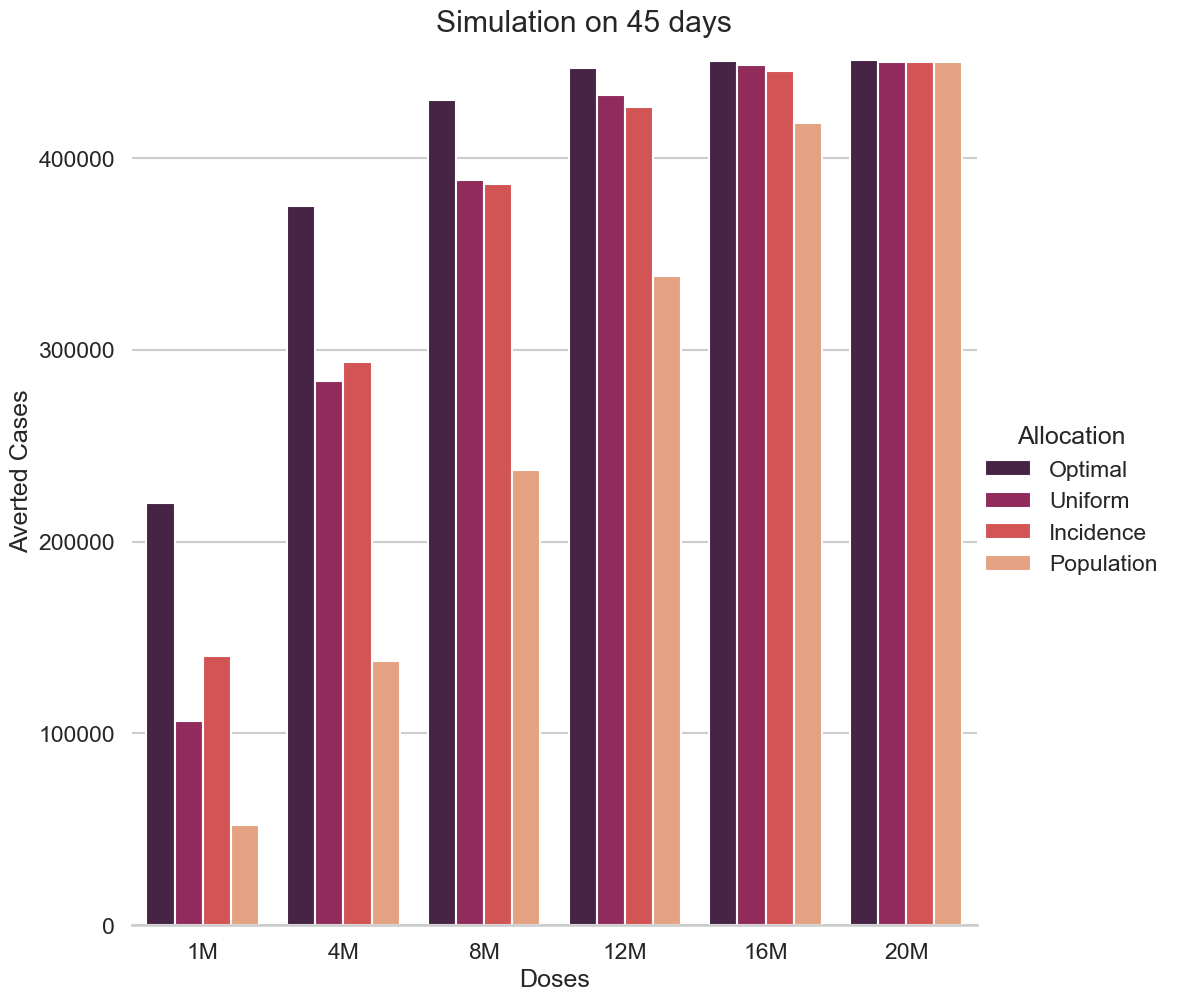

In [292]:
ndays = 45
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,10), 'figure.dpi':100})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results[scn_results['total_vacc'] > 0], kind="bar",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.fig.suptitle(f'Simulation on {ndays} days')
g.set_axis_labels("Doses", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels(['1M', '4M', '8M', '12M', '16M', '20M'])


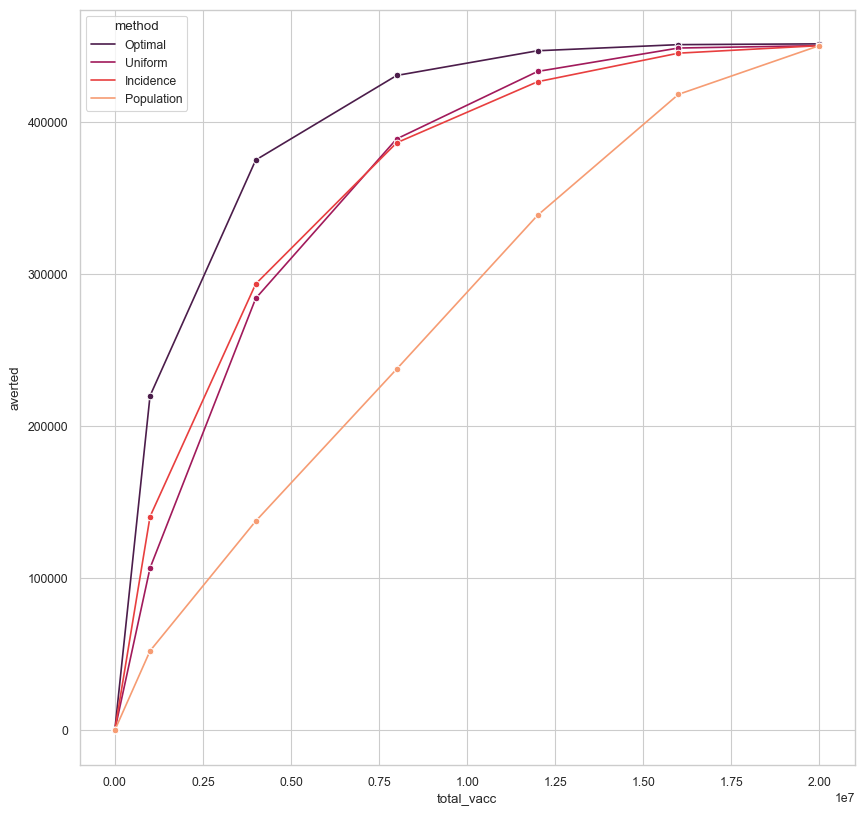

In [288]:
g = sns.lineplot(
    data=scn_results, 
    x="total_vacc", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

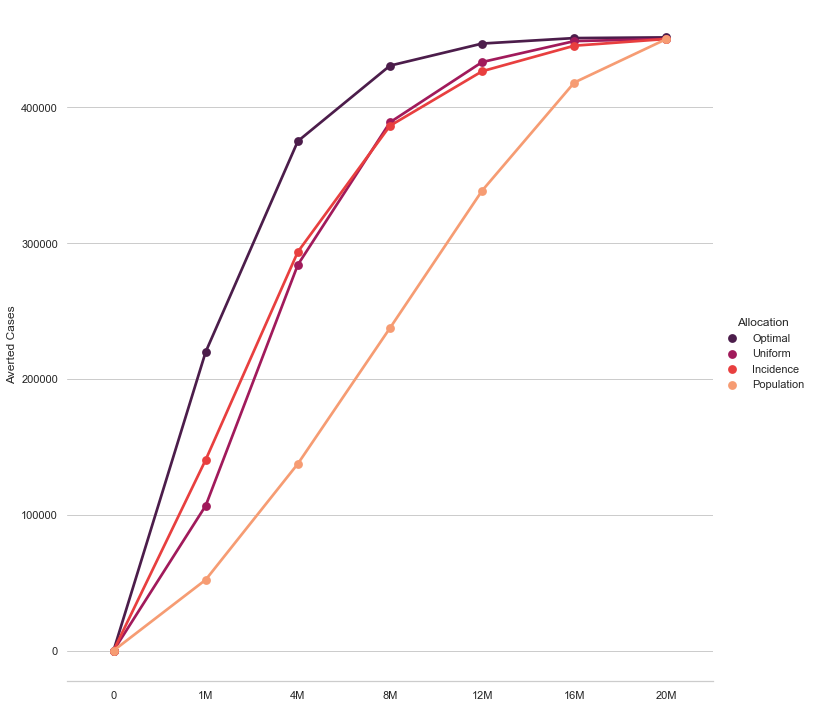

In [257]:
g = sns.catplot(
    data=scn_results, kind="point",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.set_axis_labels("", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels(['0', '1M', '4M', '8M', '12M', '16M', '20M'])

In [5]:

md = pd.read_csv(f'{outdir}{file_prefix}-opt{nnodes}-r{mvr}-m{int(8e6)}.csv', index_col= 'date', parse_dates=True)

623.4740335583602

In [310]:

G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
setup.shp['vacc'] = np.nan
setup.shp['Rend'] = np.nan
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node[i]
    #G.comp[node] = (ocp.ic['S'][i], ocp.ic['I'][i],ocp.ic['R'][i])
    G.epi[node] = {'vacc': md[(md['place']==node) & (md['comp']=='vacc')]['value'].sum(),
               'Rend':  md[(md['place']==node) & (md['comp']=='R')]['value'][-1]}
    setup.shp.loc[i, 'vacc'] = md[(md['place']==node) & (md['comp']=='vacc')]['value'].sum()
    setup.shp.loc[i, 'Rend'] = md[(md['place']==node) & (md['comp']=='R')]['value'][-1]
        
    setup.shp.loc[i, 'population'] =  setup.pop_node[i] # overwrite 
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection)
G.number_of_edges()

366

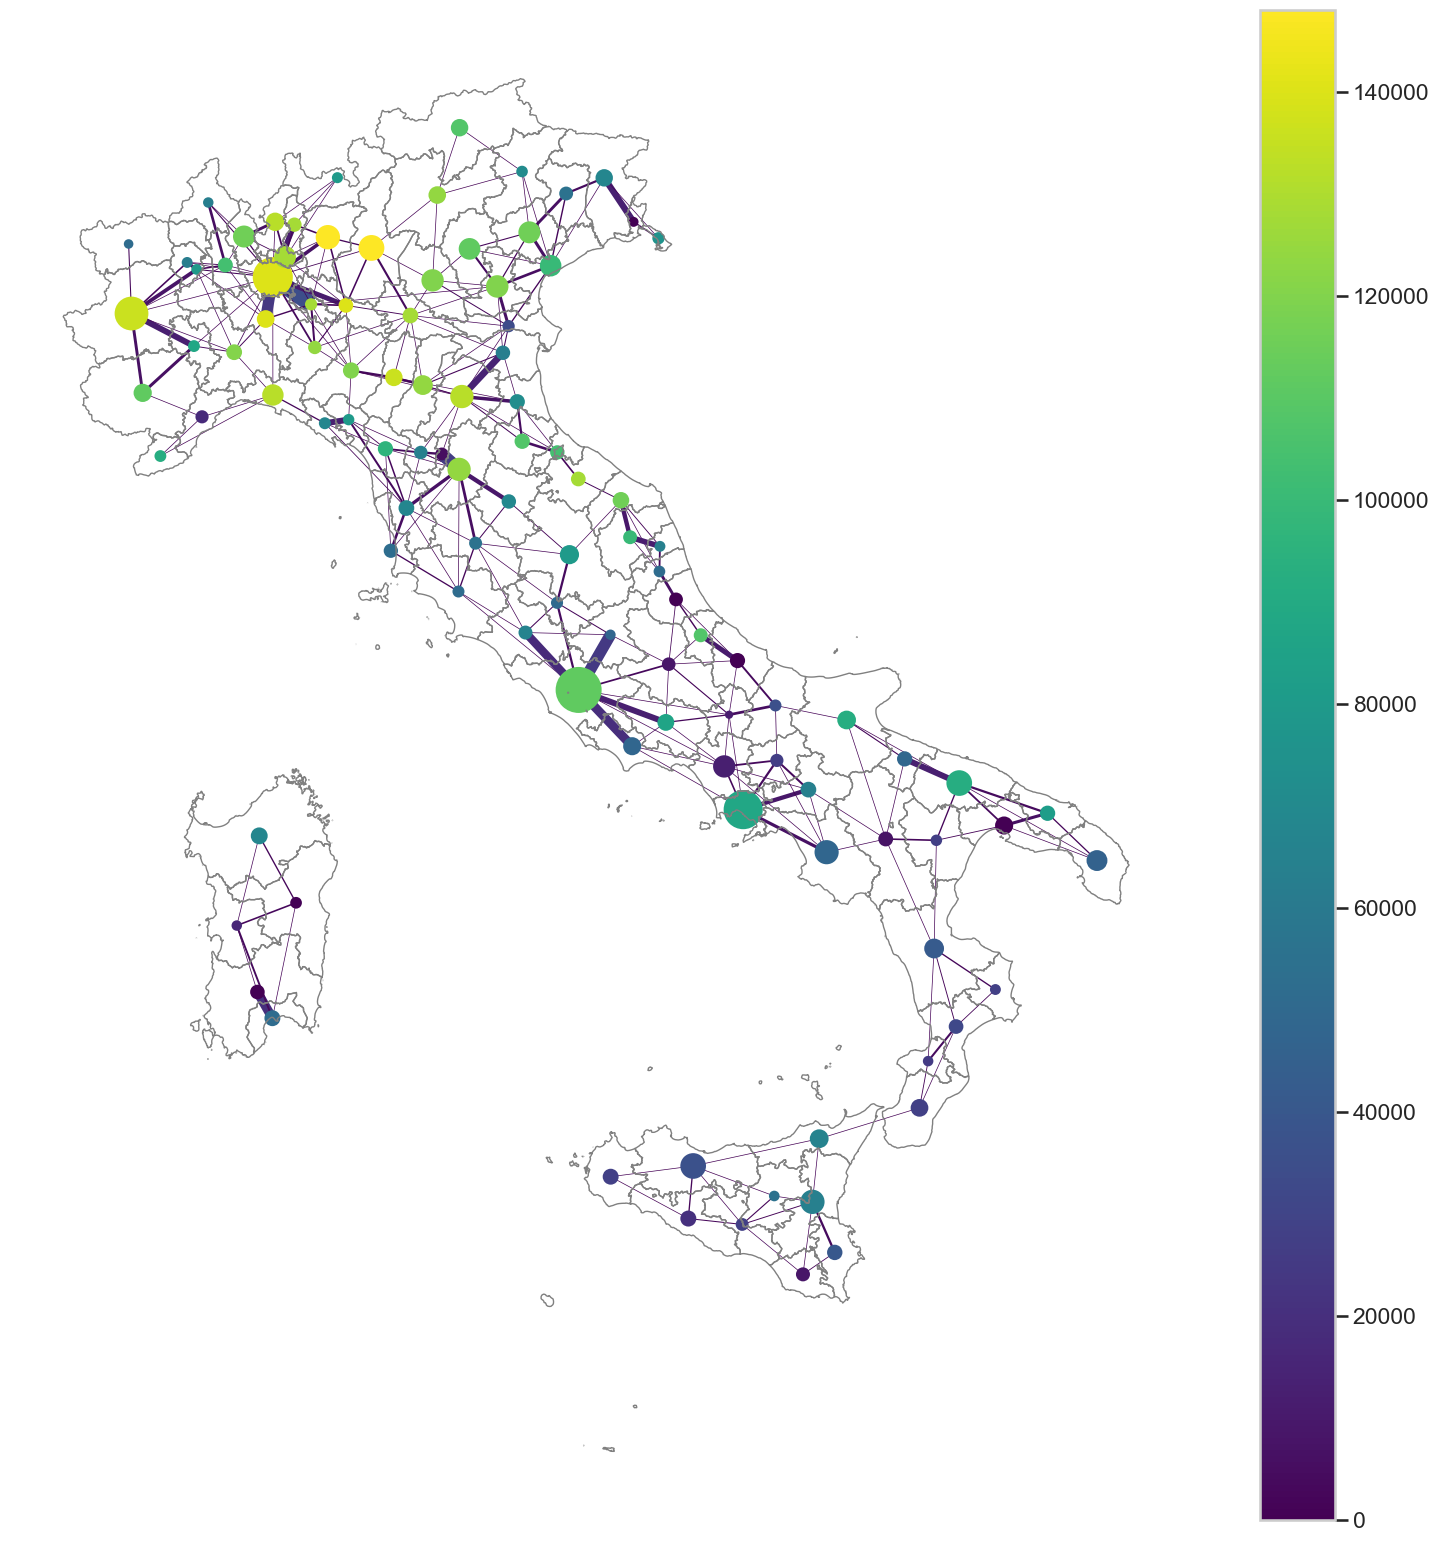

In [323]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))


networkx.draw(G, 
         G.position, 
         node_size=1000/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          #node_color=[float(G.degree(v)) for v in G],
          #node_color=[G.population[v] for v in G],
          #node_color=[G.epi[v]['vacc']/G.population[v] for v in G],
          node_color= [G.epi[v]['vacc'] for v in G],
          width = 50* np.array([max(a['weight'],0.01) for u,v,a in G.edges(data=True)]),
          edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
          edge_cmap = mpl.cm.viridis,
        cmap = mpl.cm.viridis,
          ax = ax,
         with_labels=False
       )

#     # scale the axes equally
#plt.xlim(min(s.pos_node[:,0]) - 100000, max(s.pos_node[:,0])+ 100000)
#plt.ylim(min(s.pos_node[:,1]) - 100000, max(s.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="grey", linewidth = 1)


cmap = mpl.cm.viridis#sns.cm.rocket
vmin = min([G.epi[v]['vacc'] for v in G])
vmax = max([G.epi[v]['vacc'] for v in G])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
plt.colorbar(sm)

plt.draw()

<AxesSubplot:>

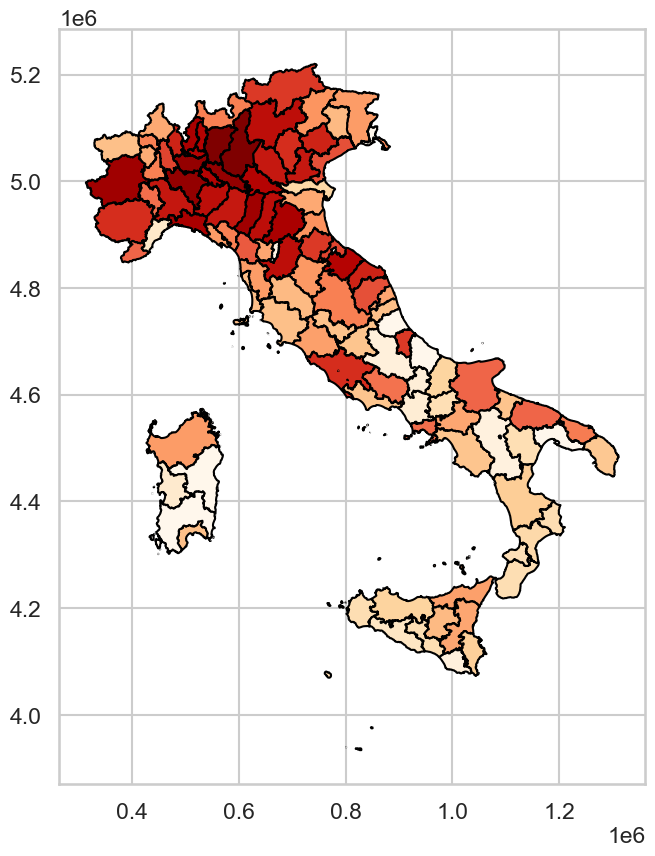

In [313]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
setup.shp.plot(ax = ax, column='vacc', cmap='OrRd',  edgecolor="black") #facecolor="none",

(0.0, 0.08083146325064906)

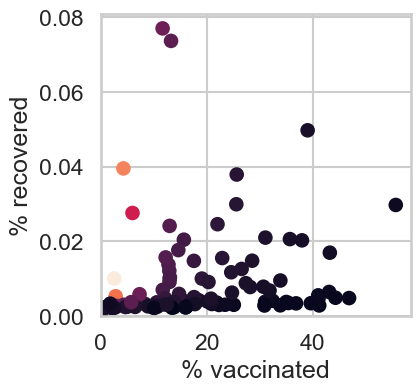

In [328]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['vacc']/setup.shp['population']*100, setup.shp['Rend']/setup.shp['population']*100, c= setup.shp['population'])
ax.set_xlabel("% vaccinated")
ax.set_ylabel("% recovered");
ax.set_xlim(0)
ax.set_ylim(0)

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


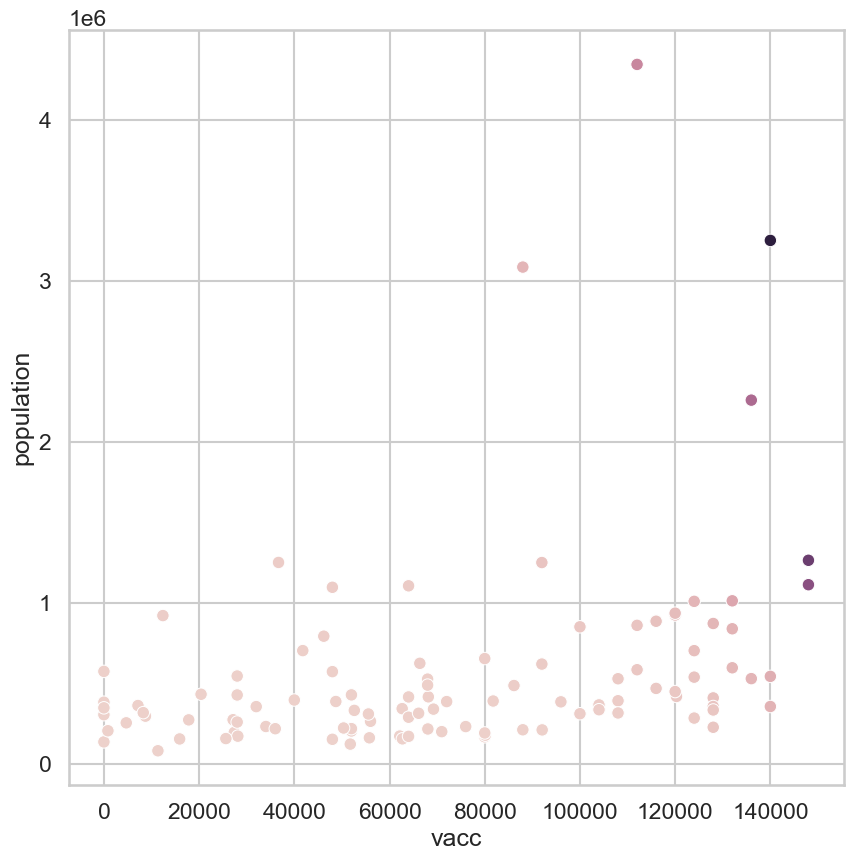

In [334]:
ax = sns.scatterplot(setup.shp['vacc'], setup.shp['population'], hue=setup.shp['Rend'])
ax.get_legend().remove();

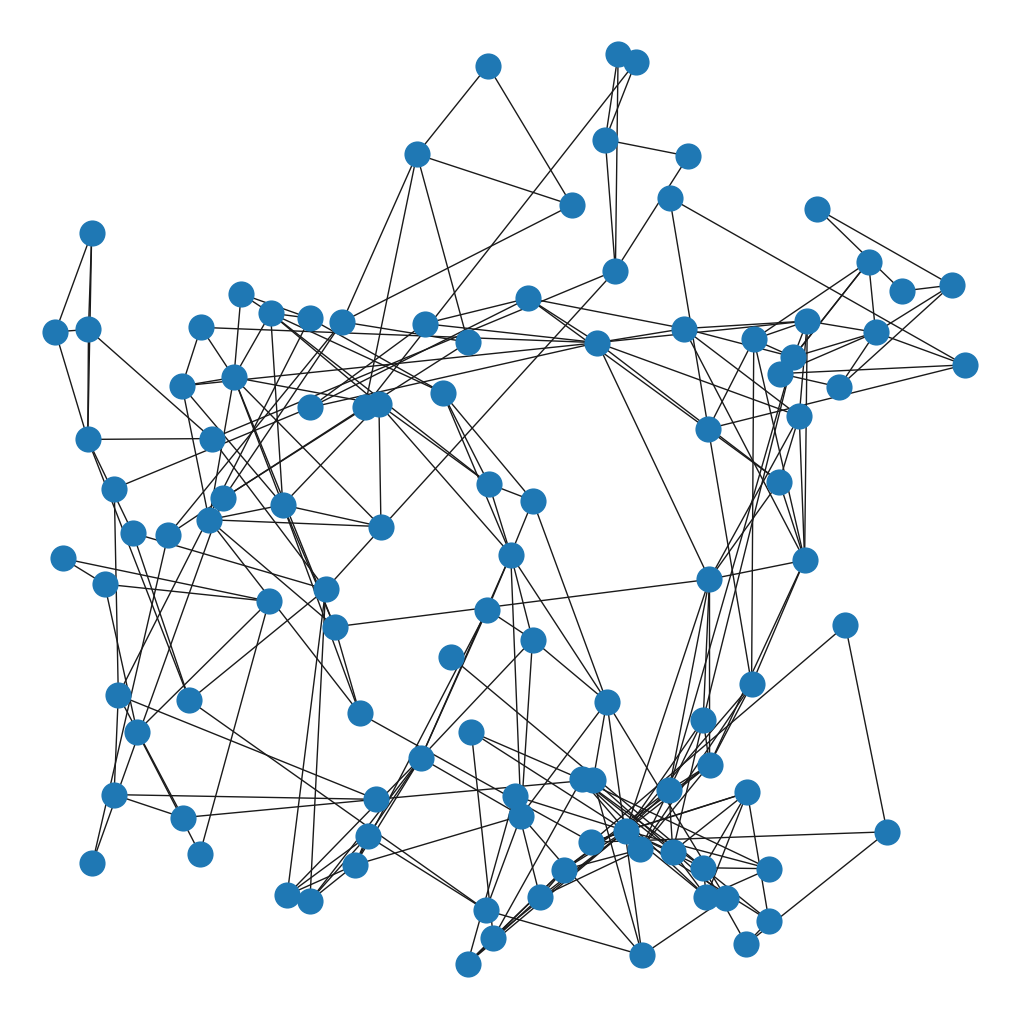

In [316]:
grph = networkx.from_numpy_matrix(p.mobmat_pr)
networkx.draw(grph)

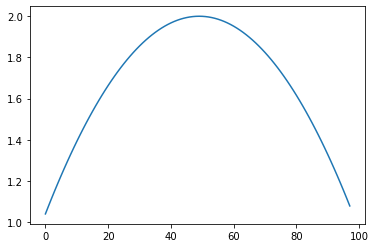

In [46]:
import scipy.interpolate
course = scipy.interpolate.interp1d([0,50,100], [1,2,1], kind='quadratic')


plt.plot(course(np.arange(1,99)))


In [53]:
np.repeat(np.arange(0,107)[:,np.newaxis], 100, axis = 1).

(107, 100)

In [57]:
p.betaratiointime.to_numpy()

array([[0.44524473, 0.44524473, 0.44524473, ..., 0.35664513, 0.35372181,
        0.24787606],
       [0.44524473, 0.44524473, 0.44524473, ..., 0.35664513, 0.35372181,
        0.24787606],
       [0.44524473, 0.44524473, 0.44524473, ..., 0.35664513, 0.35372181,
        0.24787606],
       ...,
       [0.44524473, 0.44524473, 0.44524473, ..., 0.35664513, 0.35372181,
        0.24787606],
       [0.44524473, 0.44524473, 0.44524473, ..., 0.35664513, 0.35372181,
        0.24787606],
       [0.44524473, 0.44524473, 0.44524473, ..., 0.35664513, 0.35372181,
        0.24787606]])

NameError: name 'data' is not defined